In [1]:
# %pip install vaderSentiment
# %pip install gensim

## Imports

In [1]:
import gzip
import pickle
import pandas as pd
from collections import defaultdict
import math
import numpy as np
import string
import random
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem.porter import *
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
#nltk.download('maxent_treebank_pos_tagger')
# nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import confusion_matrix, precision_score,recall_score, accuracy_score
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from textblob import TextBlob, Word

# Interactions Data

In [28]:
data_raw_interactions = pd.read_csv("RAW_interactions.csv")

In [29]:
data_raw_interactions.shape

(1132367, 5)

In [3]:
data_raw_interactions = data_raw_interactions[data_raw_interactions['rating']!=0]
data = data_raw_interactions.sample(50000, random_state = 42)
del data_raw_interactions

In [4]:
data.iloc[0,:]

user_id                                                 160974
recipe_id                                                 3034
date                                                2013-11-30
rating                                                       5
review       Just perfect for scones! It rivals any clotted...
Name: 693453, dtype: object

In [5]:
data.rating.value_counts()

5    38009
4     8813
3     1923
2      665
1      590
Name: rating, dtype: int64

In [6]:
data['sentiment'] = data.apply(lambda row: 1 if row.rating in [5,4] else 0, axis=1)
data['sentiment'] = data.apply(lambda row: -1 if row.rating in [1,2] else row.sentiment, axis=1)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

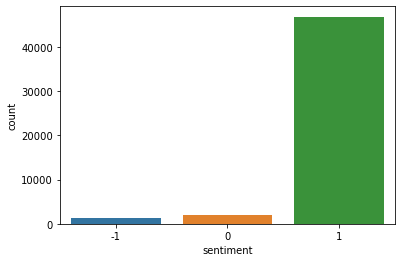

In [11]:
sns.countplot(data.sentiment)

In [50]:
data['review'] = data['review'].astype(str)

## 1. Bag of Words


In [51]:
stops = stopwords.words('english')

In [59]:
five_stars = data[data['rating'].isin([4,5])]['review']
one_stars = data[data['rating'].isin([1,2])]['review']


In [39]:
five_stars.iloc[0]

'I made these last night for a Christmas caroling party and they were devoured.  Amazing and simple!  Thanks for the recipe!'

In [53]:
def gen_wordcloud(data, max_words, stopwords):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = max_words,
        stopwords = stopwords,
        max_font_size = 40, 
        scale = 3,
        random_state = 1
    ).generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [54]:
#%pip install textblob
from textblob import TextBlob
five_stars['blobbed'] = five_stars.apply(lambda x: TextBlob(str(x)).words)
five_stars['cleaned'] = five_stars['blobbed'].apply(lambda x: list(set(x.lower()) - set(stops)))

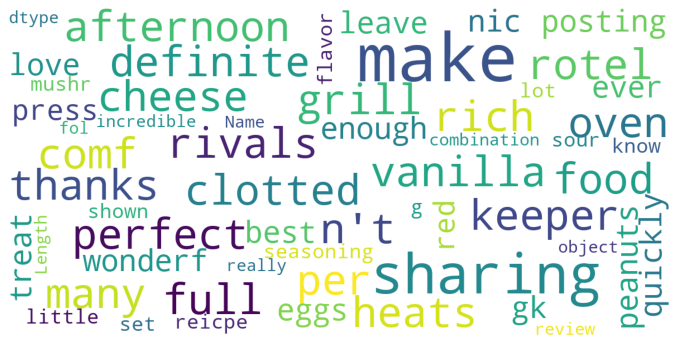

In [55]:
gen_wordcloud(five_stars['cleaned'], 200, stops)

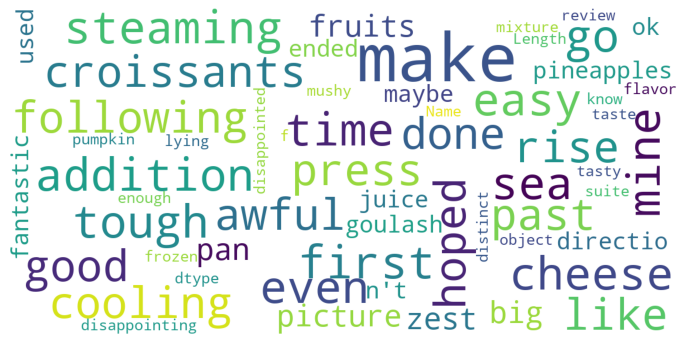

In [60]:
one_stars['blobbed'] = one_stars.apply(lambda x: TextBlob(str(x)).words)
one_stars['cleaned'] = one_stars['blobbed'].apply(lambda x: list(set(x.lower()) - set(stops)))
gen_wordcloud(one_stars['cleaned'], 200, stops)

In [57]:
del five_stars, one_stars

In [61]:
data['polarity'] = data['review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data.head()

,user_id,recipe_id,date,rating,review,sentiment,polarity
693453,160974,3034,2013-11-30,5,Just perfect for scones! It rivals any clotted...,1,0.733333
86350,35140,82743,2004-02-18,5,"What wonderful comfort food - creamy, rich, fu...",1,0.445000
1032240,227652,56347,2014-01-01,4,This was a really great recipe!!! I left out t...,1,0.193750
251377,1029636,13546,2010-10-19,5,Close to wonderful....wonderful would be havin...,1,0.700000
1025995,1182340,316845,2009-02-24,5,The best ever!!,1,1.000000


In [62]:
data['polarity_norm'] = data['review'].apply(lambda x: math.ceil(TextBlob(str(x)).sentiment.polarity))

In [63]:
print(data['polarity_norm'].value_counts())
print(data['sentiment'].value_counts())

 1    47154
 0     2830
-1       16
Name: polarity_norm, dtype: int64
 1    46822
 0     1923
-1     1255
Name: sentiment, dtype: int64


0.90236 0.914242749473494
0.9082625110569771


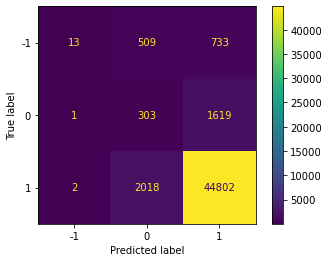

In [65]:
precision = precision_score(data['sentiment'], data['polarity_norm'], average = 'weighted')
recall = recall_score(data['sentiment'], data['polarity_norm'], average = 'weighted')
print(recall, precision)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)
ConfusionMatrixDisplay.from_predictions(data['sentiment'], data['polarity_norm'])

## VADER

In [66]:
vader= SentimentIntensityAnalyzer()
data['vader'] = data['review'].apply(lambda x: math.ceil(vader.polarity_scores(str(x))['compound']))

Recall, Precision 0.91338 0.8974318565156695
0.9053356991835989


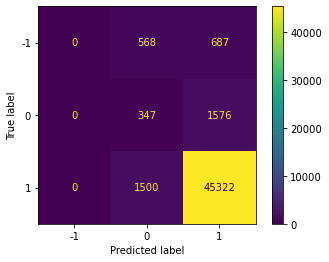

In [67]:
precision = precision_score(data['sentiment'], data['vader'], average = 'weighted')
recall = recall_score(data['sentiment'], data['vader'], average = 'weighted')
print("Recall, Precision",recall, precision)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)
ConfusionMatrixDisplay.from_predictions(data['sentiment'], data['vader'])

## TF-IDF

In [10]:
def preprocess_text(text_data):
    def lem(word):
        w = Word(word)
        return w.lemmatize()
        # Converting lowercase and removing stopwords
    preprocessed_text = ' '.join(lem(token.lower())
                                          for token in nltk.word_tokenize(text_data)
                                            if token not in string.punctuation)
  
    return preprocessed_text

In [69]:
data['review'] = data['review'].apply(lambda x : preprocess_text(x)) 

In [70]:
tv = TfidfVectorizer(max_features=5000, stop_words = stops)
X = tv.fit_transform(data['review']).toarray()

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'],
                                                    test_size=0.33,
                                                    stratify=data['sentiment'],
                                                    random_state = 42)

In [72]:
from sklearn.tree import DecisionTreeClassifier
  
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)
  
#testing the model
pred = model.predict(X_test)


In [76]:
pickle.dump(model,open('DT_TfIDF','wb'))

In [73]:
print(accuracy_score(y_test,pred))

0.9130303030303031


Recall, Precision 0.9130303030303031 0.9059986243111747
0.9095008727638364


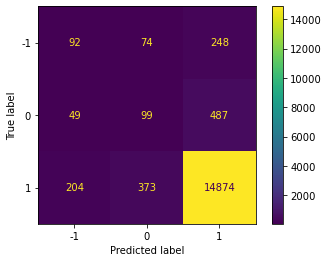

In [74]:
precision = precision_score(y_test, pred, average = 'weighted')
recall = recall_score(y_test, pred, average = 'weighted')
print("Recall, Precision",recall, precision)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)
ConfusionMatrixDisplay.from_predictions(y_test, pred)


## Word2Vec

In [78]:

w2v_model = Word2Vec(data['review'].values,  vector_size = 1000,  window = 5, sg = 1)
w2v_model.save('word2vec.model')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'],
                                                    test_size=0.33,
                                                    stratify=data['sentiment'],
                                                    random_state = 42)

In [92]:
word2vec_filename = 'train_review_word2vec.csv'
w2v_model = Word2Vec.load('word2vec.model')
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in enumerate(X_train):
        try:
            model_vector = (np.mean([w2v_model.wv[token] for token in row if token not in string.punctuation], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(1000))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(1000)])
        except:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [94]:
word2vec_df = pd.read_csv(word2vec_filename)
clf_decision_word2vec = DecisionTreeClassifier()
clf_decision_word2vec.fit(word2vec_df, y_train)

DecisionTreeClassifier()

In [96]:
test_features_word2vec = []
for index, row in enumerate(X_test):
    try:
        model_vector = np.mean([w2v_model.wv[token] for token in row], axis=0)
        if type(model_vector) is list:
            test_features_word2vec.append(model_vector)
        else:
            test_features_word2vec.append(np.array([0 for i in range(1000)]))
    except:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)

In [97]:
print(accuracy_score(y_test,test_predictions_word2vec))

0.9364242424242424


Recall, Precision 0.9364242424242424 0.8768903617998163
0.9056800081184919


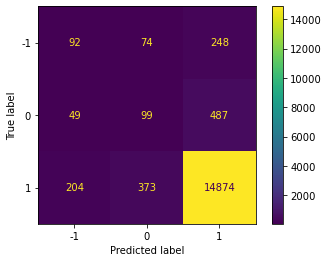

In [98]:
precision = precision_score(y_test, test_predictions_word2vec, average = 'weighted')
recall = recall_score(y_test, test_predictions_word2vec, average = 'weighted')
print("Recall, Precision",recall, precision)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)
ConfusionMatrixDisplay.from_predictions(y_test, pred)

# Recipe Data

In [33]:
#data_raw_interactions = pd.read_csv("RAW_interactions.csv")
data_raw_recipe = pd.read_csv("RAW_recipes.csv")
print(data_raw_recipe.shape)
data_raw_recipe = data_raw_recipe.sample(50000, random_state = 42)

(231637, 12)


In [31]:
data_raw_interactions.shape

(1132367, 5)

In [3]:
data = pd.merge(data_raw_interactions.loc[:,['recipe_id','rating']] ,data_raw_recipe, how = 'right',right_on='id',left_on='recipe_id')

In [4]:
cols = list(data.columns)
cols.pop(1) #remove rating
data_with_ratings = data.groupby(cols)["rating"].mean().reset_index()
del data_raw_interactions, data_raw_recipe

In [5]:
data_with_ratings['rating'] = data_with_ratings['rating'].round()

In [6]:
data_with_ratings.iloc[0,:]

recipe_id                                                        38
name                              low fat berry blue frozen dessert
id                                                               38
minutes                                                        1485
contributor_id                                                 1533
submitted                                                1999-08-09
tags              ['weeknight', 'time-to-make', 'course', 'prepa...
nutrition                  [170.9, 3.0, 120.0, 1.0, 6.0, 6.0, 12.0]
n_steps                                                          13
steps             ['toss 2 cups berries with sugar', 'let stand ...
description       this is yummy and low-fat, it always turns out...
ingredients       ['blueberries', 'granulated sugar', 'vanilla y...
n_ingredients                                                     4
rating                                                          4.0
Name: 0, dtype: object

In [7]:
data_with_ratings['name_ingredients_tags'] =  data_with_ratings["description"].astype(str) + " " + \
        data_with_ratings["ingredients"] + " " +data_with_ratings["tags"]

In [8]:
data_with_ratings.iloc[0,-1]

"this is yummy and low-fat, it always turns out perfect. ['blueberries', 'granulated sugar', 'vanilla yogurt', 'lemon juice'] ['weeknight', 'time-to-make', 'course', 'preparation', 'occasion', 'low-protein', 'healthy', '5-ingredients-or-less', 'desserts', '1-day-or-more', 'easy', 'low-fat', 'summer', 'frozen-desserts', 'freezer', 'dietary', 'low-sodium', 'gluten-free', 'low-cholesterol', 'seasonal', 'low-saturated-fat', 'low-calorie', 'healthy-2', 'free-of-something', 'low-in-something', 'equipment']"

In [11]:
data_with_ratings['pprocessed'] = data_with_ratings['name_ingredients_tags'].apply(lambda x :preprocess_text(x))


In [12]:
stops = stopwords.words('english')
tv = TfidfVectorizer(max_features=1000, stop_words = stops)
pprocessed_tfidf = tv.fit_transform(data_with_ratings['pprocessed']).toarray()

In [13]:
name_tfidf = tv.fit_transform(data_with_ratings["name"]).toarray()

In [14]:
indices = pd.Series(data_with_ratings.index,index=data_with_ratings['name'])
indices[data_with_ratings[:1]["name"][0]]

0

In [23]:
name_indices = pd.Series(data_with_ratings.index,index=data_with_ratings['name'])
pp_indices = pd.Series(data_with_ratings.index,index=data_with_ratings['pprocessed'])
def recommendation(query,sim, factor):
    re_li = []
    ind = name_indices[query] if factor =='name' else pp_indices[query]
#     ind = rec[rec["name"]==data].index[0]
    sim_score = list(enumerate(cosine_similarity(sim[ind].reshape(1,-1), sim, dense_output = False).flatten()))
    sim_score = sorted(sim_score,key=lambda x:x[1],reverse=True)
    sim_score = sim_score[0:11]
    rec_indices = [i[0] for i in sim_score]
    for i in rec_indices:
        if factor == 'pprocessed':
            factor = 'ingredients'
        re_li.append(data_with_ratings.iloc[i][factor])  
    return re_li[1:]

In [16]:
print(data_with_ratings.iloc[4,:]["name"])
recommendation(data_with_ratings.iloc[4,:]["name"],name_tfidf,'name')

black coffee barbecue sauce


['grilled chicken with coffee barbecue sauce',
 'black forest coffee',
 'coffee barbecue sauce from texas highways',
 'barbecue sauce',
 'barbecue coca cola sauce',
 'drake bulldogs superb barbecue sauce',
 'running creek barbecue sauce',
 'sexy barbecue sauce',
 'master class barbecue sauce',
 'the shack barbecue sauce']

In [27]:
print("Similar to ---", data_with_ratings.iloc[9,:]["ingredients"])
recommendation(data_with_ratings.iloc[9,:]["pprocessed"],pprocessed_tfidf,'pprocessed')

Similar to --- ['dry yeast', 'water', 'honey', 'wheat', 'oil', 'garlic clove', 'tomatoes', 'tomato sauce', 'mozzarella cheese', 'parmesan cheese', 'olive oil', 'salt', 'pepper', 'oregano', 'basil']


["['flour', 'active dry yeast', 'salt', 'warm water', 'vegetable oil', 'diced tomatoes', 'tomato paste', 'dried basil', 'oregano', 'marjoram', 'thyme', 'garlic powder', 'pepper', 'pepperoni', 'mozzarella cheese', 'parmesan cheese', 'romano cheese']",
 "['pizza dough', 'dried tomatoe', 'olive oil', 'sweet onions', 'salt & pepper', 'garlic cloves', 'anchovy paste', 'dried oregano', 'mozzarella cheese', 'parmesan cheese']",
 "['lemon juice', 'olive oil', 'eggplants', 'tomato puree', 'tomatoes', 'oregano', 'basil', 'cayenne pepper', 'garlic cloves', 'dry breadcrumbs', 'parmesan cheese', 'ricotta cheese', 'mozzarella cheese']",
 "['olive oil', 'garlic cloves', 'san marzano tomatoes', 'salt', 'fresh basil']",
 "['egg', 'milk', 'vegetable oil', 'all-purpose flour', 'eggplants', 'tomato sauce', 'tomato paste', 'tomatoes', 'burgundy wine', 'dried oregano', 'dried basil', 'dried thyme', 'garlic salt', 'salt', 'mozzarella cheese', 'parmesan cheese']",
 "['penne pasta', 'mozzarella cheese', 'basil

In [162]:
stops = set(stops)
def pos_preprocess_text(text_data,idx):
    def lem(word):
        w = Word(word)
        return w.lemmatize()
        # Converting lowercase and removing stopwords
    text_data = ' '.join(lem(token.lower())
                                          for token in nltk.word_tokenize(text_data)
                                            if token not in string.punctuation and token.lower() not in stops)
    return TaggedDocument(words=nltk.word_tokenize(text_data), tags=[str(idx)])

In [163]:
data_with_ratings['pos_pp'] = data_with_ratings.apply(lambda x : pos_preprocess_text(x['name_ingredients_tags'], x.name), axis = 1)

In [164]:
data_with_ratings['pos_pp'].values[0]

TaggedDocument(words=['yummy', 'low-fat', 'always', 'turn', 'perfect', "'blueberries", "'granulated", 'sugar', "'vanilla", 'yogurt', "'lemon", 'juice', "'weeknight", "'time-to-make", "'course", "'preparation", "'occasion", "'low-protein", "'healthy", '5-ingredients-or-less', "'desserts", '1-day-or-more', "'easy", "'low-fat", "'summer", "'frozen-desserts", "'freezer", "'dietary", "'low-sodium", "'gluten-free", "'low-cholesterol", "'seasonal", "'low-saturated-fat", "'low-calorie", "'healthy-2", "'free-of-something", "'low-in-something", "'equipment"], tags=['0'])

In [141]:
model = Doc2Vec(vector_size=1000, min_count=10, dm =0)

In [166]:
model.build_vocab(data_with_ratings['pos_pp'].values)

In [169]:
model.train(data_with_ratings['pos_pp'].values, total_examples=model.corpus_count, epochs =10)

In [170]:
model.save("d2v.model")

In [186]:
i = 1
print(data_with_ratings.iloc[i]['ingredients'])
similar = model.docvecs.most_similar(str(i), topn = 10)
recs = []
for i,_ in similar:
    recs.append(data_with_ratings.iloc[int(i)]['ingredients'])
recs

['saffron', 'milk', 'hot green chili peppers', 'onions', 'garlic', 'clove', 'peppercorns', 'cardamom seed', 'coriander seed', 'cumin seed', 'poppy seed', 'mace', 'cilantro', 'fresh lemon juice', 'plain yogurt', 'boneless chicken', 'salt', 'vegetable oil', 'ghee', 'onion', 'tomatoes', 'basmati rice', 'raisins', 'cashews', 'almonds', 'eggs']


["['plain yogurt', 'tomato puree', 'cumin', 'coriander', 'canola oil', 'paprika', 'celery seed', 'cayenne', 'salt', 'ginger', 'cardamom', 'clove', 'garlic cloves', 'chicken thighs', 'cooked basmati rice']",
 "['butter', 'garlic clove', 'onion', 'green apple', 'water', 'banana', 'honey', 'turmeric', 'curry powder', 'tomato ketchup', 'chicken broth', 'salt', 'black pepper', 'cornstarch', 'chicken breasts', 'flour', 'eggs', 'breadcrumbs', 'vegetable oil', 'carrots', 'potatoes']",
 "['chicken fillets', 'butter', 'shallot', 'green peppers', 'vegetable oil', 'bay leaves', 'cinnamon sticks', 'green cardamom pods', 'cloves', 'onion', 'garlic paste', 'ginger paste', 'ground cumin', 'ground coriander', 'turmeric powder', 'chili powder', 'tomato puree', 'plain low-fat yogurt', 'garam masala', 'salt', 'fresh coriander', 'unsalted cashews', 'water', 'cream']",
 "['skinless chicken pieces', 'onions', 'fresh ginger', 'garlic cloves', 'canola oil', 'ground coriander', 'ground cumin', 'ground turmeric'